In [22]:
%pylab inline
import os, sys, pickle
from importlib import reload
plt.style.use("default")

Populating the interactive namespace from numpy and matplotlib


In [23]:
import fisher_plumes_tools as fpt; reload(fpt);

# Notebook for debugging

## Updating the pooling functions

The pooling functions have always been complicated.
We can't just precompute because the data is very large.
But we can have a pool_for_distance function.

In [ ]:
def pool_for_distance(F,d ):
    # What we want is, for each probe,
    # a two row matrix consisting of all coefficients at one y location
    # vs corresponding coefficients at the other.
    # ss: ss[probe][dist][bs,time,fr]
    dists = sorted(list(F.pairs.keys()))    
    cs_0 = [np.concatenate([coef_prb[y0] for (ss_prb,cc_prb) in zip(Fbw.ss, Fbw.cc) for coef_prb in [ss_prb, cc_prb]], axis=1) for (y0,y1) in Fbw.pairs[dists[1]]]
    cs_1 = [np.concatenate([coef_prb[y1] for (ss_prb,cc_prb) in zip(Fbw.ss, Fbw.cc) for coef_prb in [ss_prb, cc_prb]], axis=1) for (y0,y1) in Fbw.pairs[dists[1]]]
    return [np.hstack((cs_0i,cs_1i))

    
    

## Problem with the curve fits

We're getting this error when we run ```fpt.fit_gen_exp_no_amp```:
RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
The data is in dumpiffail.p, so let's have a look.

In [1]:
# fit_gen_exp_no_amp = lambda d, la, a: curve_fit(lambda d, s, k, b: gen_exp(d, a, s, k, b),
#                                                 d, la,
#                                                 p0=[1,1,0],
#                                                 maxfev=5000,                                                
#                                                 bounds=(0, np.inf))[0]

In [34]:
with open("dumpiffail.p", "rb") as f:
    data     = pickle.load(f)
    d, la, a = data["args"]
    extra   = data["extra"]
    print(extra)
    



{'ifreq': 6, 'ibs': 4, 'iprobe': 0}


In [36]:
d, la, a

(array([0.        , 0.21693046, 0.43386092, 0.65079137, 0.86772183,
        1.08465229, 1.30158275, 1.5185132 , 1.73544366, 1.95237412,
        2.16930458, 2.38623504, 2.60316549, 2.82009595, 3.03702641,
        3.25395687]),
 array([0.04478692, 0.03412745, 0.02912778, 0.0243314 , 0.02189136,
        0.02010331, 0.01952378, 0.01935054, 0.01936651, 0.01991081,
        0.02040515, 0.02194842, 0.02380797, 0.02569658, 0.02590159,
        0.02814492]),
 0.02369497783454681)

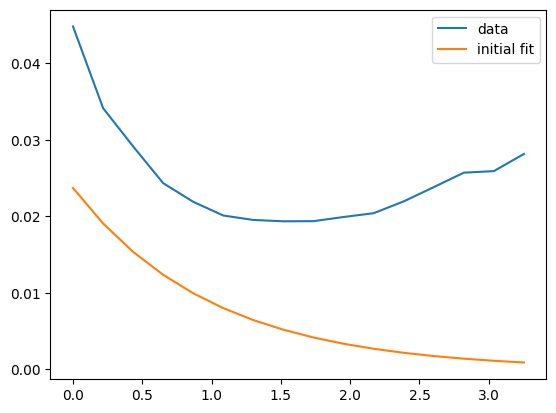

In [35]:
plot(d, la, label="data")
plot(d, fpt.gen_exp(d,a,1,1,0), label="initial fit")
legend()

In [25]:
a

0.02369497783454681

In [26]:
la[0]

0.04478692423549721